In [22]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from IPython.display import HTML, display
import json
from collections import Counter
import pandas as pd
import numpy as np
from utilities import *

register_matplotlib_converters()
pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline


ModuleNotFoundError: No module named 'ebmdatalab'

In [24]:
df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_rate.csv', parse_dates=['date'])

def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = (df[value_col]/df[population_col])*rate_per
    return num_per_thousand

df['rate'] = calculate_rate(df, 'doac', 'population')

codelist = pd.read_csv('../codelists/opensafely-mechanical-or-artificial-valves.csv')


## DOAC Use in Patients with Mechanical Heart Valves


### Total Number

In [31]:
population = df.groupby(by='date')[['population']].sum().reset_index()
events = df.groupby(by='date')[['doac']].sum().reset_index()
total_df = df.groupby(by='date')[['rate']].mean().reset_index()

total_df = total_df.merge(events, on='date').merge(population, on='date')

def redact_small_numbers(df, n, numerator, denominator, rate_column):
    """
    Takes counts df as input and suppresses low numbers.  Sequentially redacts
    low numbers from numerator and denominator until count of redcted values >=n.
    Rates corresponding to redacted values are also redacted.
    
    df: input df
    n: threshold for low number suppression
    numerator: numerator column to be redacted
    denominator: denominator column to be redacted
    """
    
    def suppress_column(column):    
        suppressed_count = column[column<=n].sum()
        
        #if 0 dont need to suppress anything
        if suppressed_count == 0:
            pass
        
        else:
            df.loc[df[column.name]<=n, column.name] = np.nan
#             df.loc[column.name][df[column.name]<=n] = np.nan
            

            while suppressed_count <=n:
                suppressed_count += column.min()
                column.iloc[column.idxmin()] = np.nan   
        return column
    
    
    for column in [numerator, denominator]:
        df[column] = suppress_column(df[column])
    
    df.loc[(df[numerator].isna())| (df[denominator].isna()), rate_column] = np.nan
#     df[rate_column][(df[numerator].isna())| (df[denominator].isna())] = np.nan
    
    return df    

total_df = redact_small_numbers(total_df, 5, 'doac', 'population', 'rate')


def plot_measures(df, title,column_to_plot, filename,category=False, y_label='Rate per 1000', interactive=True):

    if interactive:

        fig = go.Figure()

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]
                fig.add_trace(go.Scatter(
                    x=df_subset['date'], y=df_subset[column_to_plot], name=unique_category))

        else:
            fig.add_trace(go.Scatter(
                x=df['date'], y=df[column_to_plot]))

        # Set title
        fig.update_layout(
            title_text=title,
            hovermode='x',
            title_x=0.5,
            yaxis=dict(
            range=[0, 7000]
        )


        )

        fig.update_yaxes(title=y_label)
        fig.update_xaxes(title="Date")

        # Add range slider
        fig.update_layout(
            xaxis=go.layout.XAxis(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                            label="1m",
                            step="month",
                            stepmode="backward"),
                        dict(count=6,
                            label="6m",
                            step="month",
                            stepmode="backward"),

                        dict(count=1,
                            label="1y",
                            step="year",
                            stepmode="backward"),
                        dict(step="all")
                    ])
                ),
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        fig.show()

    else:

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]

                plt.plot(df_subset['date'], df_subset[column_to_plot], marker='o')
        else:
            plt.plot(df['date'], df[column_to_plot])

        plt.ylabel(y_label)
        plt.xlabel('Date')
        plt.ylim(bottom=0, top=df[column_to_plot].max() + df[column_to_plot].max()* 0.1)
        plt.xticks(rotation='vertical')
        plt.title(title)

        if category:
            plt.legend(df[category].unique(), bbox_to_anchor=(
                1.04, 1), loc="upper left")

        else:
            pass
        plt.savefig(f'../output/measure_{filename}.jpeg')
        plt.show()
        
        plt.clf()

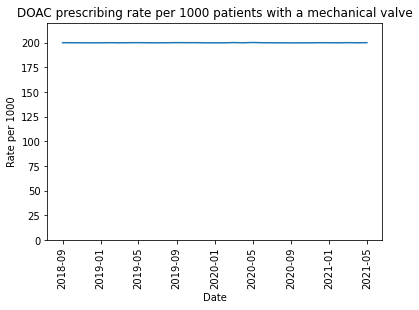

<Figure size 432x288 with 0 Axes>

In [32]:
plot_measures(total_df, title='DOAC prescribing rate per 1000 patients with a mechanical valve', column_to_plot='rate', category=False, y_label='Rate per 1000', interactive=False, filename="total")


### STP Breakdown

In [5]:
df_stp = pd.read_csv('../output/measure_stp_rate.csv', parse_dates=['date'])
df_stp['rate'] = calculate_rate(df_stp, 'doac', 'population')

deciles_chart(df_stp, period_column='date', column='rate', title='Decile chart',ylabel='rate per 1000', interactive=False)
plt.tight_layout()
plt.savefig('../output/measure_stp.jpeg')

NameError: name 'deciles_chart' is not defined

### Mechanical Valve Type

Mechanical valve type of those with mechanical valve currently prescribed a DOAC

In [19]:
def group_low_values(df, value_col, population_col, term_col):
    
    df = df[df[value_col] > 0]
    suppressed_count = df.loc[df[value_col]<=5, value_col].sum()
    population_suppressed_count = df.loc[df[value_col]<=5, population_col].sum()
    
    if suppressed_count == 0:
        pass

    else:
        df.loc[df[value_col] <=5, value_col]  = np.nan

        while suppressed_count <=10:

            suppressed_count += df[value_col].min()
            df.loc[df[value_col].idxmin(), value_col] = np.nan 
            
            population_suppressed_count += df.loc[df[value_col].idxmin(), population_col]
            df.loc[df[value_col].idxmin(), population_col] = np.nan

    dropped_rows = df.loc[df[value_col].isnull(), term_col].values

    df = df[df[value_col].notnull()]
    
    
    
    return df, dropped_rows, suppressed_count, population_suppressed_count

In [20]:
valve_type_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_valve_code_rate.csv', parse_dates=['date'])
valve_type_df_now = valve_type_df[valve_type_df['date']== '2021-05-01']
valve_type_df_now = valve_type_df_now.drop('value', axis=1)



valve_type_df_now = valve_type_df_now.merge(codelist, left_on='mechanical_valve_code', right_on='code', how='left')
valve_type_df_now = valve_type_df_now.drop(columns='code')
valve_type_df_now


valve_type_df_now, dropped_rows, suppressed_count, population_suppressed_count = group_low_values(valve_type_df_now, 'doac_3_months', 'population', 'term')


FileNotFoundError: [Errno 2] No such file or directory: '../output/measure_doac_rx_mechanical_valve_3_month_valve_code_rate.csv'

In [8]:
valve_type_df_now

,mechanical_valve_code,doac_3_months,population,date,term
0,NaN,2426.0,12000,2021-05-01,NaN
1,174920003.0,574.0,3000,2021-05-01,Prosthetic mitral valve replacement (& [Bjork ...


In [9]:
print(f'suppressed count: {suppressed_count}')
print(f'population suppressed: {population_suppressed_count}')
print(dropped_rows)

suppressed count: 0.0
population suppressed: 0
[]


### Demographic breakdown

#### Sex

In [10]:
sex_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_sex_rate.csv', parse_dates=['date'])

def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = (df[value_col]/df[population_col])*rate_per
    return num_per_thousand

sex_df['rate'] = calculate_rate(sex_df, 'doac_3_months', 'population')

sex_df_now = sex_df[sex_df['date'] == '2021-05-01']
sex_df_now = sex_df_now.drop('value', axis=1)

sex_df_now, dropped_rows, suppressed_count, population_suppressed_count = group_low_values(sex_df_now, 'doac_3_months', 'population', 'sex')
sex_df_now

,sex,doac_3_months,population,date,rate
96,F,1518.0,7479,2021-05-01,202.968311
97,M,1467.0,7394,2021-05-01,198.404111
98,U,15.0,127,2021-05-01,118.110236


In [11]:
print(f'suppressed count: {suppressed_count}')
print(f'population suppressed: {population_suppressed_count}')
print(dropped_rows)

suppressed count: 0.0
population suppressed: 0
[]


#### Ethnicity

In [12]:
ethnicity_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_ethnicity_rate.csv', parse_dates=['date'])

def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = (df[value_col]/df[population_col])*rate_per
    return num_per_thousand

ethnicity_df['rate'] = calculate_rate(ethnicity_df, 'doac_3_months', 'population')

ethnicity_df_now = ethnicity_df[ethnicity_df['date'] == '2021-05-01']
ethnicity_df_now = ethnicity_df_now.drop('value', axis=1)

ethnicity_df_now, dropped_rows, suppressed_count, population_suppressed_count = group_low_values(ethnicity_df_now, 'doac_3_months', 'population', 'eth2001')
ethnicity_df_now

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,eth2001,doac_3_months,population,date,rate
288,NaN,2705.0,13511.0,2021-05-01,200.207239
289,1.0,155.0,747.0,2021-05-01,207.496653
290,2.0,75.0,369.0,2021-05-01,203.252033
291,3.0,29.0,183.0,2021-05-01,158.469945
292,4.0,19.0,NaN,2021-05-01,180.952381


In [13]:
print(f'suppressed count: {suppressed_count}')
print(f'population suppressed: {population_suppressed_count}')
print(dropped_rows)

suppressed count: 17.0
population suppressed: 133
[5. 6. 8.]


#### IMD

In [14]:
imd_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_imd_rate.csv', parse_dates=['date'])

def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = (df[value_col]/df[population_col])*rate_per
    return num_per_thousand

imd_df['rate'] = calculate_rate(ethnicity_df, 'doac_3_months', 'population')

imd_df_now = imd_df[imd_df['date'] == '2021-05-01']
imd_df_now = imd_df_now.drop('value', axis=1)

imd_df_now, dropped_rows, suppressed_count, population_suppressed_count = group_low_values(imd_df_now, 'doac_3_months', 'population', 'imd')
imd_df_now

,imd,doac_3_months,population,date,rate
192,NaN,2404.0,12000,2021-05-01,196.428571
193,1.0,126.0,635,2021-05-01,240.384615
194,12001.0,105.0,558,2021-05-01,263.157895
195,18001.0,104.0,587,2021-05-01,120.000000
196,24001.0,128.0,604,2021-05-01,187.500000
197,6001.0,133.0,616,2021-05-01,142.857143


In [15]:
print(f'suppressed count: {suppressed_count}')
print(f'population suppressed: {population_suppressed_count}')
print(dropped_rows)

suppressed count: 0.0
population suppressed: 0
[]


#### Age Band

In [16]:
age_df = pd.read_csv('../output/measure_doac_rx_mechanical_valve_3_month_age_rate.csv', parse_dates=['date'])

def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = (df[value_col]/df[population_col])*rate_per
    return num_per_thousand

age_df['rate'] = calculate_rate(age_df, 'doac_3_months', 'population')

age_df_now = age_df[age_df['date'] == '2021-05-01']
age_df_now = age_df_now.drop('value', axis=1)

age_df_now, dropped_rows, suppressed_count, population_suppressed_count = group_low_values(age_df_now, 'doac_3_months', 'population', 'age_band')
age_df_now

,age_band,doac_3_months,population,date,rate
289,0-19,376.0,1867.0,2021-05-01,201.392608
290,20-29,381.0,1908.0,2021-05-01,199.685535
291,30-39,379.0,1854.0,2021-05-01,204.422869
292,40-49,364.0,NaN,2021-05-01,193.926478
294,60-69,374.0,1880.0,2021-05-01,198.936170
295,70-79,395.0,1898.0,2021-05-01,208.113804
296,80+,375.0,1871.0,2021-05-01,200.427579


In [17]:
print(f'suppressed count: {suppressed_count}')
print(f'population suppressed: {population_suppressed_count}')
print(dropped_rows)

suppressed count: 356.0
population suppressed: 1896
['0' '50-59']
